# Project 1: Digit Classification with KNN and Naive Bayes

Author: Aaron Olson

In this project, you'll implement your own image recognition system for classifying digits. Read through the code and the instructions carefully and add your own code where indicated. Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but <b> please prepare your own write-up (with your own code). </b>

If you're interested, check out these links related to digit recognition:

Yann Lecun's MNIST benchmarks: http://yann.lecun.com/exdb/mnist/

Stanford Streetview research and data: http://ufldl.stanford.edu/housenumbers/

In [35]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# Import a bunch of libraries.
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_mldata
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report

# Set the randomizer seed so results are the same each time.
np.random.seed(0)

Load the data. Notice that we are splitting the data into training, development, and test. We also have a small subset of the training data called mini_train_data and mini_train_labels that you should use in all the experiments below, unless otherwise noted.

In [36]:
# Load the digit data either from mldata.org, or once downloaded to data_home, from disk. The data is about 53MB so this cell
# should take a while the first time your run it.
mnist = fetch_mldata('MNIST original', data_home='~/datasets/mnist')
X, Y = mnist.data, mnist.target

# Rescale grayscale values to [0,1].
X = X / 255.0

# Shuffle the input: create a random permutation of the integers between 0 and the number of data points and apply this
# permutation to X and Y.
# NOTE: Each time you run this cell, you'll re-shuffle the data, resulting in a different ordering.
shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X[shuffle], Y[shuffle]

print ('data shape: ', X.shape)
print ('label shape:', Y.shape)

# Set some variables to hold test, dev, and training data.
test_data, test_labels = X[61000:], Y[61000:]
dev_data, dev_labels = X[60000:61000], Y[60000:61000]
train_data, train_labels = X[:60000], Y[:60000]
mini_train_data, mini_train_labels = X[:1000], Y[:1000]

data shape:  (70000, 784)
label shape: (70000,)


(1) Create a 10x10 grid to visualize 10 examples of each digit. Python hints:

- plt.rc() for setting the colormap, for example to black and white
- plt.subplot() for creating subplots
- plt.imshow() for rendering a matrix
- np.array.reshape() for reshaping a 1D feature vector into a 2D matrix (for rendering)

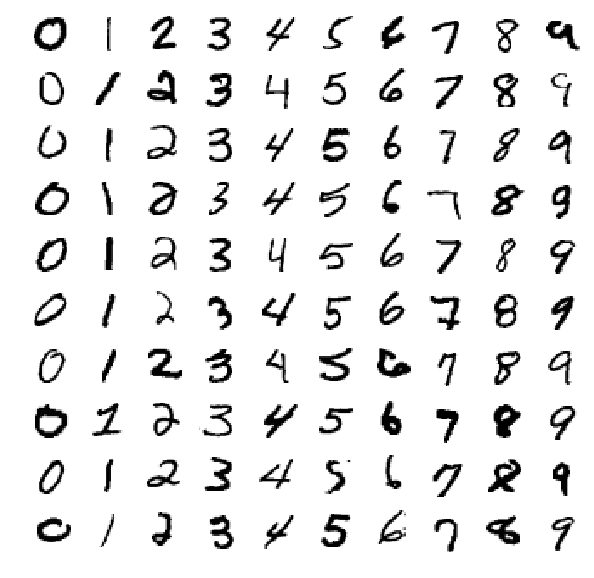

In [37]:
def P1(num_examples):
    """Prints a grid of num_examples of the digits 0-9
    
    Prints images of the labeled MNIST dataset. The function first defines
    an array Z the size of the image grid and with the appropriate labels. 
    It then loops over the rows and then the columns to find a digit in the 
    dataset of the appropriate label and the print the label to the screen.
    
    Args:
        num_examples - number of rows (examples) for each digit
    Returns:
        N/A - prints to screen
    """
    
    Z = np.zeros([num_examples,10], dtype = float)
    # Define the Z matrix
    for y in range(0,num_examples):
        for i in range(0,10):
            Z[y,i] = float(i)
    fig, axs = plt.subplots(num_examples, 10, figsize = (10,10))
    i = 0
    # Print the image matrix using the Z matrix
    for ax, w in zip(axs.flat, Z.flat):
        i = i + 1
        ax.set_axis_off()
        ax.imshow(train_data[np.where(train_labels == w)][i].reshape((28,28)), 
                  cmap = plt.cm.gray_r, interpolation = 'nearest', aspect = 'equal')

    plt.show()

P1(10)

(2) Evaluate a K-Nearest-Neighbors model with k = [1,3,5,7,9] using the mini training set. Report accuracy on the dev set. For k=1, show precision, recall, and F1 for each label. Which is the most difficult digit?

- KNeighborsClassifier() for fitting and predicting
- classification_report() for producing precision, recall, F1 results

In [38]:
def P2(k_values):
    """Fits a k-nearest neighbors model for multiple k values

    Loops over a list of k values to fit a knn model and 
    determine the accuracy. For the first model (k=1)
    additionally print the classification report.

    Args:
        k_values - The number of neighbors to look at in the knn model

    Returns:
        N/A - prints to screen
    """
    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors = k)
        knn.fit(mini_train_data, mini_train_labels)
        if k == 1:
            print("Classification report, k = 1")
            print(classification_report(dev_labels, knn.predict(dev_data)))
        print("k: %d     Accuracy: %.3f" %(k, knn.score(dev_data, dev_labels)))


k_values = [1, 3, 5, 7, 9]
P2(k_values)

Classification report, k = 1
             precision    recall  f1-score   support

        0.0       0.91      0.98      0.94        99
        1.0       0.89      1.00      0.94       105
        2.0       0.99      0.79      0.88       102
        3.0       0.77      0.87      0.82        86
        4.0       0.89      0.82      0.85       104
        5.0       0.93      0.84      0.88        91
        6.0       0.94      0.96      0.95        98
        7.0       0.89      0.92      0.90       113
        8.0       0.94      0.88      0.91        96
        9.0       0.78      0.82      0.80       106

avg / total       0.89      0.89      0.89      1000

k: 1     Accuracy: 0.888
k: 3     Accuracy: 0.878
k: 5     Accuracy: 0.869
k: 7     Accuracy: 0.865
k: 9     Accuracy: 0.863


ANSWER: 
By analyzing the classification report (for k=1), we can see that the lowest precision correlated with the 3 digit and the lowest recall correlated with the 2 digit. 

Precision = Number of positives correctly labeled = $\frac{True Positive}{True Positive + False Positive}$
Recall = Existing positives correctly labeled = $\frac{True Positive}{True Positive + False Negative}$
F1 Score: A weighted mean of the precision and recall. 

By using the F1 score, which strives to balance the precision and recall, the worst performing digit is the 3. 

(3) Using k=1, report dev set accuracy for the training set sizes below. Also, measure the amount of time needed for prediction with each training size.

- time.time() gives a wall clock value you can use for timing operations

In [39]:
def P3(train_sizes, accuracies):
    """Use different training sizes to fit k-nearest neighbors model
    
    Prints accuracies of a knn model (k=1) using list of training
    sizes. Also measure the time it takes to complete the model training.
    
    Args:
        train_sizes - the size of the training set
        accuracies - array passed into function to track accuracy values
        
    Returns:
        accuracies - appended values accessible outside of function call
    """

    for size in train_sizes:
        start_time = time.time()
        knn = KNeighborsClassifier(n_neighbors = 1)
        knn.fit(train_data[:size], train_labels[:size])
        elapsed_time = time.time() - start_time
        print("Train Size: %5d     Accuracy: %.3f     Time: %.1f sec" 
              %(size, knn.score(dev_data, dev_labels), elapsed_time))
        accuracies.append(knn.score(dev_data, dev_labels))
train_sizes = [100, 200, 400, 800, 1600, 3200, 6400, 12800, 25000]
accuracies = []
P3(train_sizes, accuracies)

Train Size:   100     Accuracy: 0.720     Time: 0.0 sec
Train Size:   200     Accuracy: 0.786     Time: 0.0 sec
Train Size:   400     Accuracy: 0.841     Time: 0.0 sec
Train Size:   800     Accuracy: 0.884     Time: 0.0 sec
Train Size:  1600     Accuracy: 0.902     Time: 0.1 sec
Train Size:  3200     Accuracy: 0.926     Time: 0.2 sec
Train Size:  6400     Accuracy: 0.937     Time: 0.7 sec
Train Size: 12800     Accuracy: 0.959     Time: 2.4 sec
Train Size: 25000     Accuracy: 0.970     Time: 8.5 sec


ANSWER: 
As expected, as the training size increases, the accuracy and time to train also increases.  

(4) Fit a regression model that predicts accuracy from training size. What does it predict for n=60000? What's wrong with using regression here? Can you apply a transformation that makes the predictions more reasonable?

- Remember that the sklearn fit() functions take an input matrix X and output vector Y. So each input example in X is a vector, even if it contains only a single value.

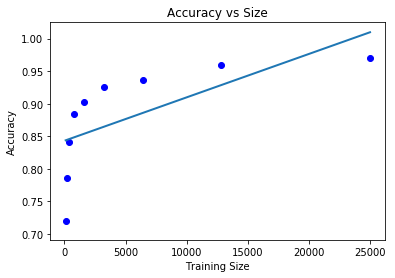

Accuracy no transformation: 1.243
Accuracy using log transformation: 1.034
Accuracy using exp(-250/train_size) transformation 0.953


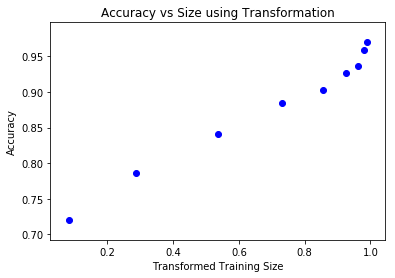

In [40]:
def P4():
    """Fit regression model to predict accuracy from training size
    
    Using arrays of training sizes and accuracies fit a linear 
    regression model to predict accuracy. In addition use 
    log and exponential transformation to training size (independent
    variable) to predict accuracy (dependent variable).
    
    Args: 
        N/A
    Returns: 
        N/A - Print to screen
    """
    
    # Normal Linear Regression Line
    lm = LinearRegression()
    lm.fit(np.array(train_sizes).reshape(-1, 1), accuracies)
    accuracy_60000 = lm.predict(60000)

    plt.scatter(train_sizes, accuracies, color = 'blue')
    plt.plot(train_sizes, lm.predict(np.array(train_sizes).reshape(-1, 1)), linewidth = 2)
    plt.xlabel("Training Size")
    plt.ylabel("Accuracy")
    plt.title("Accuracy vs Size")
    plt.show()
    print("Accuracy no transformation: %.3f" %(accuracy_60000[0]))
    
    # Log Transformation Regression Line
    lm.fit(np.log(np.array(train_sizes).reshape(-1, 1)), accuracies)
    accuracy_60000 = lm.predict(np.log(60000))
    print("Accuracy using log transformation: %.3f" %(accuracy_60000[0]))

    
    # Exp(-1/train_size) Transfomration Regression Line
    trans_train_sizes = []
    for y in train_sizes:
        trans_train_sizes.append(np.exp(-250/y))
    
    lm.fit(np.array(trans_train_sizes).reshape(-1, 1), accuracies)
    accuracy_60000_transform = lm.predict(np.exp(-250/60000))
    print("Accuracy using exp(-250/train_size) transformation %.3f" 
          %(accuracy_60000_transform[0]))
    plt.scatter(trans_train_sizes, accuracies, color = 'blue')
    plt.xlabel("Transformed Training Size")
    plt.ylabel("Accuracy")
    plt.title("Accuracy vs Size using Transformation")
    plt.show()

P4()

From the first plot above, we can see that the relationship between training size and accuracy is not linear. Therefore fitting a linear regression line isn't a valid way to predict data. Furthermore, by trying to extrapolate beyond the present data, to a training size of 60,000. Using linear regression we get Accuracy[60,000] = 1.24 which cannot be true because perfect accuracy is 1.0.

There are a couple of transformations that can be applied. The first and most basic is a log transformation. Looking at the distribution of accuracy and size we see what appears to approximate a log transformation. By training a linear regression: Accuracy = \beta_1log(train_size) + \beta_0 we obtain an accuracy of 1.03 which is still non-sensible. 

Further analysis of the distribution looks as though it fits a negative exponential curve. 

$$Accuracy = e ^ {\frac{250}{train-size}}$$

The second plot shows the distribution after applying the transformation to training size. Here we can see there is closer to a linear relationship up to an Accuracy ~ 0.95. Using this transformation the predicted accuracy is 0.95 which is more reasonable than previous estimations, but is within the non-linear region of the distribution, therefore the regression estimation at this point may not be accurate. 

Fit a 1-NN and output a confusion matrix for the dev data. Use the confusion matrix to identify the most confused pair of digits, and display a few example mistakes.

- confusion_matrix() produces a confusion matrix

Confusion matrix:
[[ 99   0   0   0   0   0   0   0   0   0]
 [  0 105   0   0   0   0   0   0   0   0]
 [  1   0  98   2   0   0   0   1   0   0]
 [  0   0   0  83   0   1   0   0   1   1]
 [  0   0   0   0 102   0   0   0   0   2]
 [  1   0   0   0   0  88   0   0   1   1]
 [  1   0   0   0   1   0  96   0   0   0]
 [  0   0   1   0   0   0   0 111   0   1]
 [  1   0   1   2   0   2   1   0  89   0]
 [  0   0   0   0   0   0   0   0   0 106]]


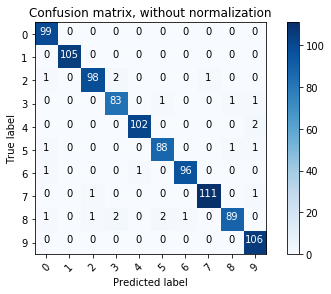

In [41]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def P5():
    """Create and plot a confusion matrix for a knn model
    
    Using a k-nearest neighbor (k=1) model. Print a confusion 
    matrix to the screen to see distribution of predicted
    vs true numbers. Also call the plot_confusion_matrix
    function to plot confusion matrix in nice format. 
    
    Args:
        N/A
    Returns:
        N/A
    """
    
    knn = KNeighborsClassifier(n_neighbors = 1)
    knn.fit(train_data, train_labels)
    predicted = knn.predict(dev_data)
    cf_matrix = confusion_matrix(dev_labels, predicted)
    print("Confusion matrix:\n%s" % cf_matrix)   
    
    class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
    plt.figure()
    plot_confusion_matrix(cf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

P5()

From the confusion matrix, we can see that the most occurences of mislabeled data is 2 counts, which appears at multiple digit combinations (2,3)(4,9)(8,3)(8,5). 

(6) A common image processing technique is to smooth an image by blurring. The idea is that the value of a particular pixel is estimated as the weighted combination of the original value and the values around it. Typically, the blurring is Gaussian -- that is, the weight of a pixel's influence is determined by a Gaussian function over the distance to the relevant pixel.

Implement a simplified Gaussian blur by just using the 8 neighboring pixels: the smoothed value of a pixel is a weighted combination of the original value and the 8 neighboring values. Try applying your blur filter in 3 ways:
- preprocess the training data but not the dev data
- preprocess the dev data but not the training data
- preprocess both training and dev data

Note that there are Guassian blur filters available, for example in scipy.ndimage.filters. You're welcome to experiment with those, but you are likely to get the best results with the simplified version I described above.

In [42]:
from scipy.ndimage import gaussian_filter
def blur_image_gaussian_filter(data):
    """Use sklearn gaussian_filter function to smooth image
    
    Using the sklearn gaussian_filter function, create smoothed
    dataset using sigma = 1. 
    
    Args:
        data - Matrix of X rows and 784 columns to represent 28x28 pixel image.
    Returns:
        N/A - Matrix passed through function
    """
    for x in range(len(data)):
        img = data[x].reshape(28,28)
        data[x] = gaussian_filter(img, sigma=1).reshape(784)

def blur_image(data):
    """Use gaussian kernel to blur image
    
    ***This is a slower implementation compared to the blur_image_gaussian_filter
    function. For processing a large dataset, it is advantageous to utilize
    the blur_image_gaussian_filter. The blur_image filter is presented here
    as a personal implementation of a gaussian filter. By default the
    blur_image filter is used.
    
    Using a gaussian kernel move pixel by pixel accros 2D matrix representing
    image applying a weighting function (kernel) to define pixel value. For
    edge pixels (top, left, bottom, right) use pixel's default value.
    
    Args:
        data - Matrix of X rows and 784 columns to represent 28x28 pixel image
    Returns:
        N/A - Blurred matrix passed through function
    """
    gaussian = np.array([0.0625, 0.125, 0.0625, 0.125, 0.25, 
                         0.125, 0.0625, 0.125, 0.0625]).reshape(3,3)
    for x in range(len(data)):
        image = data[x].reshape(28,28)
        image_filtered = np.zeros((28,28), dtype = float)
        it = np.nditer(image, flags=['multi_index'])
        # Loop over 28x28 image pixel by pixel
        while not it.finished:
            # Edge detection - if edge keep value of original pixel
            if it.multi_index[0] == 0 or it.multi_index[0] == 27 or it.multi_index[1] == 0 or it.multi_index[1] == 27:
                image_filtered[it.multi_index[0]][it.multi_index[1]] = it[0]
                it.iternext()
                continue 
            pixel_value = 0

            itl = np.nditer(gaussian, flags=['multi_index'])
            # Loop over gaussian kernel to determine pixel-value
            # multi_index keeps track of the index of the loop
            while not itl.finished:
                pixel_value = pixel_value + itl[0] * image[it.multi_index[0] + 
                                                           (itl.multi_index[0]-1)][it.multi_index[1] + 
                                                                                   (itl.multi_index[1]-1)]
                image_filtered[it.multi_index[0]][it.multi_index[1]] = pixel_value
                itl.iternext()
            it.iternext()
        data[x] = image_filtered.reshape(784)
    
train_data_blur = np.copy(train_data)
dev_data_blur = np.copy(dev_data)

blur_image(train_data_blur)
blur_image(dev_data_blur)

In [43]:
def P6():
    """ Using varying arrays of blurred and non blurred images,
    fit knn (k=1) to compute accuracy on a development set. 
    
    Args:
        N/A
    Return:
        N/A - Matrix passed through function
    """

    # No Blur
    knn = KNeighborsClassifier(n_neighbors = 1)
    knn.fit(train_data, train_labels)
    print("No Blur - Accuracy: %25.3f" %(knn.score(dev_data, dev_labels)))
    # Train Blur
    knn = KNeighborsClassifier(n_neighbors = 1)
    knn.fit(train_data_blur, train_labels)
    print("Training Set Blur - Accuracy: %15.3f" %(knn.score(dev_data, dev_labels)))
    # Dev Blur
    knn = KNeighborsClassifier(n_neighbors = 1)
    knn.fit(train_data, train_labels)
    print("Dev Set Blur - Accuracy: %20.3f" %(knn.score(dev_data_blur, dev_labels)))
    # Both Blur
    knn = KNeighborsClassifier(n_neighbors = 1)
    knn.fit(train_data_blur, train_labels)
    print("Both Train and Dev Set Blur - Accuracy: %.3f" %(knn.score(dev_data_blur, dev_labels)))

P6()

No Blur - Accuracy:                     0.977
Training Set Blur - Accuracy:           0.981
Dev Set Blur - Accuracy:                0.964
Both Train and Dev Set Blur - Accuracy: 0.980


ANSWER: 
We can see that the highest accuracy was achieved when both the training and dev sets were blurred. While intuitively this may seem strange, by blurring we effectively spread out the pixel value count to surrounding cells, which may make digit recongnition easier. 

The lowest accuracy was correlated with only blurring the training set. This makes sense intuitively, because the knn algorithm was trained on a non-blurred dataset but the development set has blurred images, which could throw off the model. 

(7) Fit a Naive Bayes classifier and report accuracy on the dev data. Remember that Naive Bayes estimates P(feature|label). While sklearn can handle real-valued features, let's start by mapping the pixel values to either 0 or 1. You can do this as a preprocessing step, or with the binarize argument. With binary-valued features, you can use BernoulliNB. Next try mapping the pixel values to 0, 1, or 2, representing white, grey, or black. This mapping requires MultinomialNB. Does the multi-class version improve the results? Why or why not?

In [44]:
from sklearn.preprocessing import binarize
def P7():
    """Change pixel values to binary and multinomial to 
        train NB classifier
    
    Using different threshold levels, preprocess the dataset into 
    binary values for both training and development sets. Fit a 
    Bernoulli NB classifier at different threshold values and 
    report accuracy.
    
    Latter half splits the train and dev data into 3 classes 
    using two different threshold values, trains a multinomial 
    NB classifier and reports accuracy. 
    
    Args:
        N/A
    Returns:
        N/A - Print to screen
    
    """
    #Bernoulli NB
    for thresh in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]:
        train_binary = binarize(train_data, thresh)
        dev_binary = binarize(dev_data, thresh)
        clf = BernoulliNB()
        clf.fit(train_binary, train_labels)
        binary_score = clf.score(dev_binary, dev_labels)
        print("Threshold Value: %.1f     Score using Bernoulli NB: %.3f" 
              %(thresh, binary_score))
    
    #Multinomial NB
    multi_cat = lambda x: 0 if x<=0.6 else (1 if x<=0.9 else 2)
    vfunc = np.vectorize(multi_cat)
    train_multi = vfunc(train_data)
    dev_multi = vfunc(dev_data)
    clf_m = MultinomialNB()
    clf_m.fit(train_multi, train_labels)
    multi_score = clf_m.score(dev_multi, dev_labels)
    print("Score using Multinomial NB: " + str(round(multi_score,4)))
P7()

Threshold Value: 0.1     Score using Bernoulli NB: 0.836
Threshold Value: 0.2     Score using Bernoulli NB: 0.834
Threshold Value: 0.3     Score using Bernoulli NB: 0.841
Threshold Value: 0.4     Score using Bernoulli NB: 0.840
Threshold Value: 0.5     Score using Bernoulli NB: 0.845
Threshold Value: 0.6     Score using Bernoulli NB: 0.843
Threshold Value: 0.7     Score using Bernoulli NB: 0.834
Threshold Value: 0.8     Score using Bernoulli NB: 0.833
Threshold Value: 0.9     Score using Bernoulli NB: 0.820
Score using Multinomial NB: 0.837


ANSWER:
For the Bernoulli NB classifier different threshold values were used to define 0 or 1 based on pixel value. We can see that the highest accuracy for this classifier is at a threshold of 0.5 (meaning that all pixel values equal to or less than 0.5 are mapped to a 0 and all values greater than 0.5 map to a 1).

Looking at the multinomial accuracy score, there is a slightly lower score than what was achieved using binomial. Multiple threshold levels were tried for the multinomial approach and all were lower than the average accuracy achieved from Bernoulli NB. Thinking about digit classification, a binomial approach makes the most sense, in order to define digit structure. Using three different classifications (white, grey, black) obscures some of the structure, and makes it harder for a knn model to determine the shape of the digit and therefore the digit classification.  

(8) Use GridSearchCV to perform a search over values of alpha (the Laplace smoothing parameter) in a Bernoulli NB model. What is the best value for alpha? What is the accuracy when alpha=0? Is this what you'd expect?

- Note that GridSearchCV partitions the training data so the results will be a bit different than if you used the dev data for evaluation.

In [47]:
def P8(alphas):
    """Use GridSearch to optimize alpha parameter in Bernoulli-NB
    
    Using varying values for the alpha (smoothing) parameter,
    use grid search to determine the optimal performing
    value for alpha and print accuracy.
    
    Args:
        alphas - list of values for laplace smoothing algorithm
    Returns:
        clf - Bernoulli NB model after training
    
    """
    nb = BernoulliNB()
    clf = GridSearchCV(nb, alphas)
    clf.fit(train_binary, train_labels)
    print('Best Score %.5f' %(clf.best_score_))
    
    return clf
    
train_binary = binarize(train_data, 0.5)
dev_binary = binarize(dev_data, 0.5)
alphas = {'alpha': [0.0, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}
nb = P8(alphas)

C:\Users\AOlson\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\Users\AOlson\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\Users\AOlson\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


Best Score 0.83712


C:\Users\AOlson\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


In [48]:
print (nb.best_params_)

{'alpha': 0.0}


ANSWER:
The best parameter is associated with an alpha value of 0 or no smoothing. Note: There was an error using alpha = 0 in the function call, therefore a small value 1.0e-10 was used instead. 

In the above example, we have binary values for the pixel (0 or 1). When computing the probablity that a given image is a specific digit, we look at a specific pixel and determine how many images in our training set with that given digit label have the same pixel value. Using alpha, we apply laplace smoothing 
$$ \hat\theta = \frac{x_i + \alpha}{N + \alpha*d}$$
Looking at Bernoulli NB documentation, the default value of alpha is 1, or add-one smoothing. As mentioned previously, the top performer was associated with an alpha value of 0. If we think of laplace smoothing in terms of the bag of words example, smoothing helps to allow new words that are not contained within the training dataset. In images, our features are limited by the pixels in an image, therefore no new pixels are observed where we cannot categorize the data. This way of thinking, helps explain why no smoothing gives the best results for this categorization problem.

(9) Try training a model using GuassianNB, which is intended for real-valued features, and evaluate on the dev data. You'll notice that it doesn't work so well. Try to diagnose the problem. You should be able to find a simple fix that returns the accuracy to around the same rate as BernoulliNB. Explain your solution.

Hint: examine the parameters estimated by the fit() method, theta\_ and sigma\_.

In [49]:
from sklearn.decomposition import PCA
def P9():
    """Fit image dataset using a Gaussian Naive Bayes model
    
    Fit a gaussian NB model by default and report accuracy. 
    Use principal component analysis (PCA) to reduce 
    dimensionality of dataset and re-fit model reporting
    accuracy
    
    Args:
        N/A
    Returns:
        N/A - Print to screen
    """
    # Gaussian Default
    clf = GaussianNB()
    clf.fit(train_data, train_labels)
    print('Score: %10.3f     Mean: %.2f     Std Dev: %.2f' 
          %(clf.score(dev_data, dev_labels), np.mean(clf.theta_), np.mean(clf.sigma_)))

    # Perform PCA
    pca = PCA(n_components = 30).fit(train_data)
    train_data_pca = pca.transform(train_data)
    dev_data_pca = pca.transform(dev_data)
    
    # Gaussian using PCA
    clf = GaussianNB()
    clf.fit(train_data_pca, train_labels)
    print('Score using PCA: %.3f' %(clf.score(dev_data_pca, dev_labels)))

gnb = P9()

Score:      0.571     Mean: 0.13     Std Dev: 0.05
Score using PCA: 0.859


ANSWER:
As can be observed, the score using default Gaussian is 0.571 whcih is fairly low. This has to do with the curse of dimensionality. In a 28x28 pixel image, there are a significant number of features to train the model on, which creates a sparse matrix. 

We can verify this by looking at the theta (mean) and sigma (std dev). The mean and std dev are both very low, indicating a sparse matrix and the potential for dimensionality problems. 

In order to help the problem of dimensionality, prinicipal component analysis can be used to find a hyperplane. Optimum performance for PCA was achieved by using n_components = 30. Applying PCA and re-training the gaussian model, a score of 0.858 was achieved. 

(10) Because Naive Bayes is a generative model, we can use the trained model to generate digits. Train a BernoulliNB model and then generate a 10x20 grid with 20 examples of each digit. Because you're using a Bernoulli model, each pixel output will be either 0 or 1. How do the generated digits compare to the training digits?

- You can use np.random.rand() to generate random numbers from a uniform distribution
- The estimated probability of each pixel is stored in feature\_log\_prob\_. You'll need to use np.exp() to convert a log probability back to a probability.

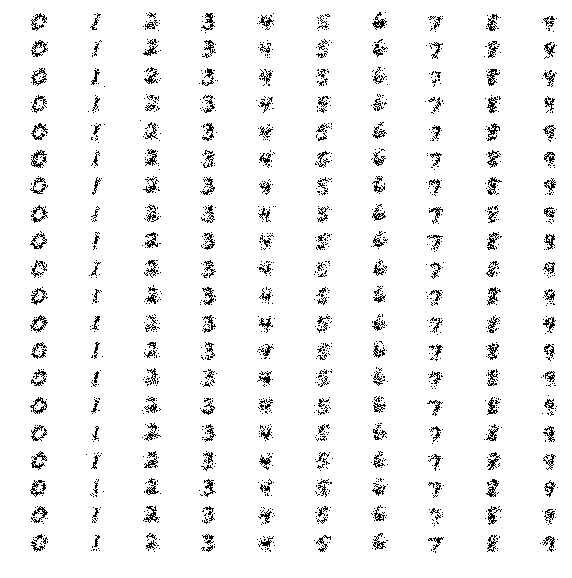

In [50]:
import random
def p10(num_examples):
    """Generate numbers from random distribution
    
    Using the pixel probablity for a particular digit
    compare a randomly generated array of numbers
    to binarize the data based using pixel probability
    as a threshold. Then display a grid of generated
    digits.
    
    Ars:
        num_example - number of rows of repeated digits
    Returns:
        N/A - Print to screen
    
    """
    # Initiate correctly labeled array of integers
    Z = np.zeros([num_examples, 10], dtype = int)
    for y in range(0,num_examples):
        for i in range(0,10):
            Z[y,i] = int(i)
    fig, axs = plt.subplots(num_examples, 10, figsize = (10,10))
    
    # Loop over each value in array
    for ax, w in zip(axs.flat, Z.flat):
        ax.set_axis_off()
        # Initate random value array, and compare to digit 
        # probability as threshold in binarization
        random_row = np.random.rand(784,)
        random_digit = random_row < pixel_value[w]
        random_digit = random_digit.astype(int)
        ax.imshow(random_digit.reshape((28,28)), cmap = plt.cm.gray_r, 
                  interpolation = 'nearest', aspect = 'equal')
    plt.show()

train_binary = binarize(train_data, 0.4)
dev_binary = binarize(dev_data, 0.4)
clf = BernoulliNB()
clf.fit(train_binary, train_labels)
pixel_value = np.exp(clf.feature_log_prob_)
p10(20)

ANSWER:
As can be observed in the above image, the generated digits are significantly fuzzier than the training examples. This is a byproduct of binarizing the data, as well as generating an image from probability. When hand-writing a digit, pen strokes wouldn't create the fuzzy image. However after training a model, the predicted probability for a specific pixel may vary based on different hand-written training examples. 

(11) Remember that a strongly calibrated classifier is rougly 90% accurate when the posterior probability of the predicted class is 0.9. A weakly calibrated classifier is more accurate when the posterior is 90% than when it is 80%. A poorly calibrated classifier has no positive correlation between posterior and accuracy.

Train a BernoulliNB model with a reasonable alpha value. For each posterior bucket (think of a bin in a histogram), you want to estimate the classifier's accuracy. So for each prediction, find the bucket the maximum posterior belongs to and update the "correct" and "total" counters.

How would you characterize the calibration for the Naive Bayes model?

In [51]:
def P11(buckets, correct, total):
    """ Fit a Bernoulli Naive Bayes algorithm and count predicted
    probability into buckets of defined probability in order to 
    compare calibration of model - looking at posterior probability
    and accuracy. 
    
    Args:
        buckets - list of floats to define probability buckets
        correct - count by bucket threshold of correctly identified
            images
        total - count by bucket threshold of all images correlated
    Returns:
        N/A - Matrix passed through function
    
    """
    # Preprocess image data to binarize at threshold of 0.5
    train_binary = binarize(train_data, 0.5)
    dev_binary = binarize(dev_data, 0.5)
    # Train Bernoulil NB model
    clf = BernoulliNB(alpha = 0.001)
    clf.fit(train_binary, train_labels)
    probs = clf.predict_proba(train_binary)
    predict = clf.predict(train_binary)
    # Loop over length of probability array 
    index = 0
    for row in probs:
        i = 0
        # Loop through bucket thresholds
        for bucket in buckets:
            # Determine if probability falls within bucket
            # Compute total and correct by bucket
            if row.max() <= bucket:
                total[i] = total[i] + 1
                if train_labels[index] == predict[index]:
                    correct[i] = correct[i] + 1
            i = i + 1
        index = index + 1

buckets = [0.5, 0.9, 0.999, 0.99999, 0.9999999, 0.999999999, 
           0.99999999999, 0.9999999999999, 1.0]
correct = [0 for i in buckets]
total = [0 for i in buckets]

P11(buckets, correct, total)
# Print bucket, total and accuracy
for i in range(len(buckets)):
    accuracy = 0.0
    if (total[i] > 0): accuracy = correct[i] / total[i]
    print('p(pred) <= %.13f    total = %5d    accuracy = %.3f' %(buckets[i], total[i], accuracy))

p(pred) <= 0.5000000000000    total =    44    accuracy = 0.364
p(pred) <= 0.9000000000000    total =  2539    accuracy = 0.404
p(pred) <= 0.9990000000000    total =  7864    accuracy = 0.472
p(pred) <= 0.9999900000000    total = 12561    accuracy = 0.528
p(pred) <= 0.9999999000000    total = 17001    accuracy = 0.577
p(pred) <= 0.9999999990000    total = 21330    accuracy = 0.625
p(pred) <= 0.9999999999900    total = 25605    accuracy = 0.666
p(pred) <= 0.9999999999999    total = 29464    accuracy = 0.697
p(pred) <= 1.0000000000000    total = 60000    accuracy = 0.838


ANSWER:

Analyzing the bucket value vs accuracy score, we can see that this model is a weakly calibrated classifier. It is true that as the bucket value increases, the accuracy score also increases, however accuracy score does not match the bucket value. 

(12) EXTRA CREDIT

Try designing extra features to see if you can improve the performance of Naive Bayes on the dev set. Here are a few ideas to get you started:
- Try summing the pixel values in each row and each column.
- Try counting the number of enclosed regions; 8 usually has 2 enclosed regions, 9 usually has 1, and 7 usually has 0.

Make sure you comment your code well!

In [52]:
from sklearn.preprocessing import normalize
def add_feature(data):
    """Add sums over image row and column
    
    Loads each image and creates 28 features for 
    summation over rows and an additional 28 features 
    for summation over each column. Additionally
    sums over entire pixel as extra feature
    
    Args:
        data - original data array
    Returns: 
        data_added - new array with additional
        columns for summation features
    """
    # Initialize empty array for column, row and total summation
    sums = np.zeros([len(data), 28*2], dtype = float)
    total_sum = np.zeros([len(data), 1])
    # Initialize empty array of correct size
    data_added = np.empty([len(data), data.shape[1] + 28*2+1])
    # Loop over each row (image) to compute summation features
    for x in range(len(data)):
        image = data[x].reshape(28,28)
        row_sum = np.sum(image, axis = 1)
        row_sum = row_sum/np.amax(row_sum)
        column_sum = np.sum(image, axis = 0)
        total_sum[x] = np.sum(data[x])
        sums[x] = np.append(row_sum, column_sum) 
    sums_norm = sums / np.amax(sums) 
    total_sum_norm = total_sum / np.amax(total_sum)
    sums_norm = np.append(sums_norm, total_sum_norm, axis = 1)
    data_added = np.append(data, sums_norm, axis = 1)
    return data_added

    
def P12():
    """Run a k nearest neighbor classification model
    
    Run a knn (k=1) classification model to predict 
    using the development set and report accuracy
    
    Args:
        N/A
    Returns:
        N/A - Print to screen
    
    """
    train_data_added = add_feature(train_data)
    dev_data_added = add_feature(dev_data)

    knn = KNeighborsClassifier(n_neighbors = 1)
    knn.fit(train_data_added, train_labels)
    print("Added Feature Accuracy: %.3f" %knn.score(dev_data_added, dev_labels))

P12()

Added Feature Accuracy: 0.977


ANSWER: 
We can see that adding the summation features didn't affect the accuracy of the knn model. In question 6 we trained a knn (k=1) classifier with an accuracy of 0.977. Initially, sums were included as features without normalization, which caused a drop in accuracy down to 0.91. Examining the dataset, it was observed that all pixel images have been normalized, however the added features varied between 0 and 20, which skewed the fit of the model. By dividing by the maximum value in the array, sums have been normalized and therefore are similar to the other featurs. 

Total pixel summation was also included as an added feature. The original thinking was that a 1 would have a lower sum than an 8 and may present some additional information for the model. However none of the features made an impact on model performance as defined by the score metric. 